### To effectively predict daily subway ridership in NYC, we explored a range of predictive models, encompassing both linear and non-linear approaches (RandomForest, RNN), to identify the algorithm that best captures the underlying patterns and maximizes predictive accuracy.


In [258]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import joblib
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from joblib import dump 
from sklearn.pipeline import Pipeline
import xgboost as xgb
from catboost import CatBoostRegressor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [259]:
# loading and preprocessing data
file_path = './cleaned_daily_ridership_weather_holi_data.csv'
df = pd.read_csv(file_path, parse_dates=['date'])
print('data shape: ', df.shape)
# preparing trian and test datasets with scaled data
X = df.drop(columns=['ridership', 'holidayName', 'date', 'weather_code', 'apparent_temperature_mean']) # dropping apparent_temp_mean because it highly correlates with temperature_2m_mean
y = df['ridership']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# standardizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

data shape:  (1325, 21)


In [260]:
# building a dataframe to track the models and perforamnce scores
model_comparison_df = pd.DataFrame(columns=['Model Name', 'RMSE', 'R-squared'])

# Linear Regression

R-squared: 0.580
RMSE: 515576.77
Mean Squared Error: 265819410404.35
Coefficients: [ -52941.81354868 -117376.90805091  -96968.64798869  -33821.45693709
  -37628.36580118   17775.79677324  -26319.9653364   -47186.90568001
  115351.22097148 -625160.74192176 -204848.88328649 -107339.7368023
  231379.35474767   10686.64891243   10669.37139115  -50161.82980482]
Intercept: 2938750.98

Feature Importance:
temp_2m_range                                           231379.354748
shortwave_radiation_sum                                 115351.220971
precipitation_hours                                      17775.796773
weather_categories_Clear or Fair Weather                 10686.648912
weather_categories_Precipitation (Light to Moderate)     10669.371391
wind_speed_10m_max                                      -26319.965336
precipitation_sum                                       -33821.456937
snowfall_sum                                            -37628.365801
wind_direction_10m_dominant           

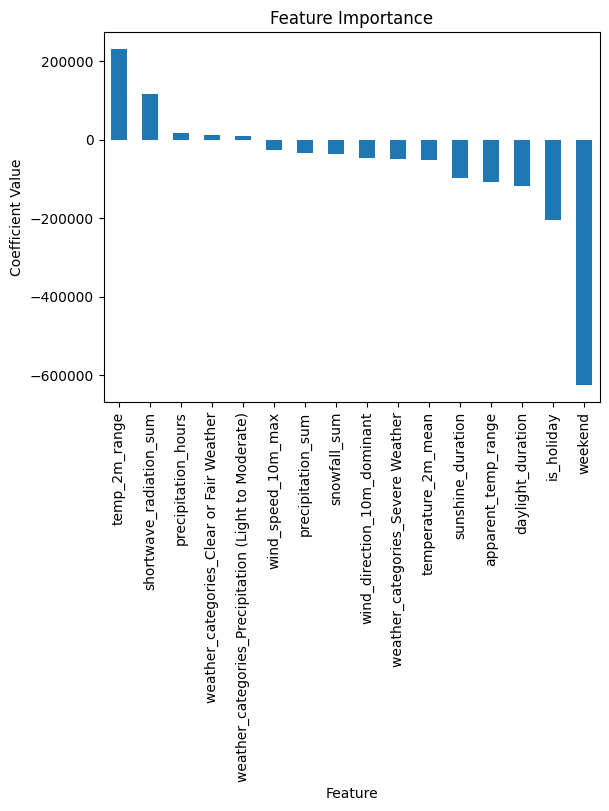

,Model Name,RMSE,R-squared
0,Linear Regression,515576.774501,0.579565


In [261]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_y_pred = lr_model.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f"R-squared: {lr_r2:.3f}")
lr_rmse = np.sqrt(lr_mse) 
print(f"RMSE: {lr_rmse:.2f}")
print(f"Mean Squared Error: {lr_mse:.2f}")
print(f"Coefficients: {lr_model.coef_}")
print(f"Intercept: {lr_model.intercept_:.2f}")

# extracting feature importance (coefficients)
lr_feature_importance = pd.Series(lr_model.coef_, index=X.columns).sort_values(ascending=False)

# visualizing feature importance
print("\nFeature Importance:")
print(lr_feature_importance)

# Plot feature importance
lr_feature_importance.plot(kind='bar', title="Feature Importance")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.show()

lr_results = {'Model Name': 'Linear Regression',
              'RMSE': lr_rmse,
              'R-squared': lr_r2}
model_comparison_df = pd.concat([model_comparison_df, pd.Series(lr_results).to_frame().T], ignore_index=True)
model_comparison_df.head()


OLS Model Results:
R-squared: 0.580
RMSE: 515576.77
Mean Squared Error: 265819410404.35

Model Summary:
                            OLS Regression Results                            
Dep. Variable:              ridership   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     114.2
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          3.22e-197
Time:                        09:08:15   Log-Likelihood:                -13467.
No. Observations:                 927   AIC:                         2.697e+04
Df Residuals:                     911   BIC:                         2.704e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.0

/var/folders/02/nw__lfcn0wx_1ww6266fv69m0000gn/T/ipykernel_21367/2272110074.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


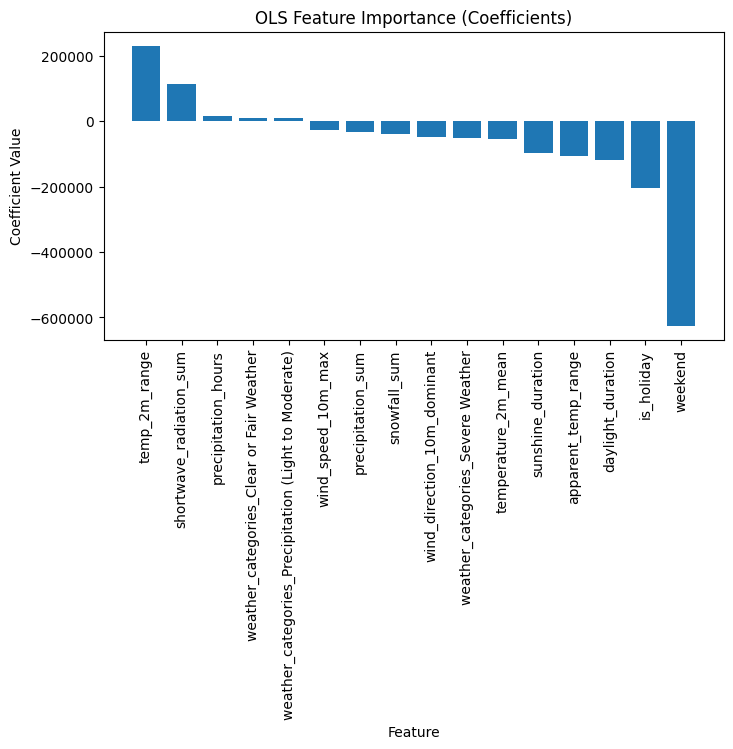

/var/folders/02/nw__lfcn0wx_1ww6266fv69m0000gn/T/ipykernel_21367/2272110074.py:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


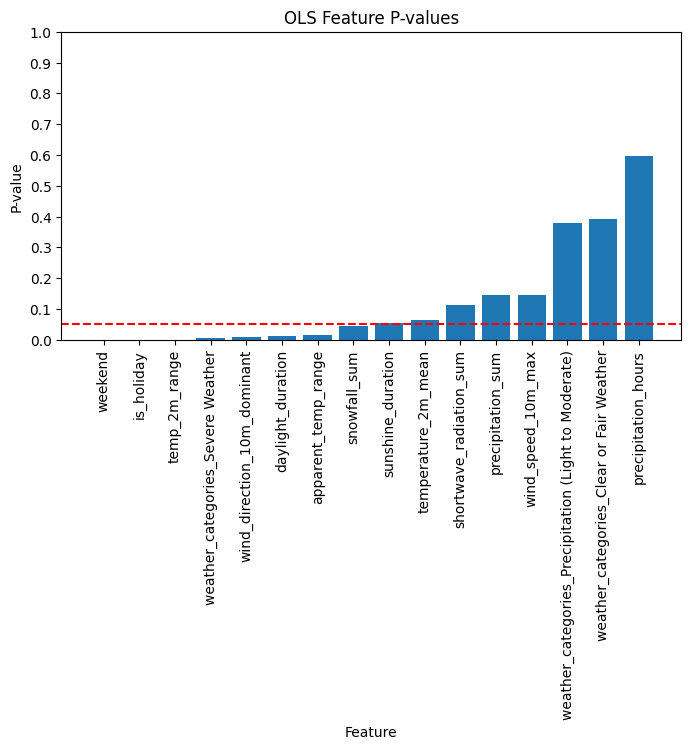

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

X_train_ols = sm.add_constant(X_train_scaled_df)
X_test_ols = sm.add_constant(X_test_scaled_df)

# Train the OLS model using statsmodels
ols_model = sm.OLS(y_train, X_train_ols).fit()
y_pred_ols = ols_model.predict(X_test_ols)

mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)
rmse_ols = np.sqrt(mse_ols)

print("OLS Model Results:")
print(f"R-squared: {r2_ols:.3f}")
print(f"RMSE: {rmse_ols:.2f}")
print(f"Mean Squared Error: {mse_ols:.2f}")
print("\nModel Summary:")
print(ols_model.summary())

# Extract feature importance (coefficients) and p-values
coefficients = ols_model.params[1:] 
p_values = ols_model.pvalues[1:]    

feature_importance_ols = pd.Series(coefficients, index=X_train_scaled_df.columns).sort_values(ascending=False)
p_values_series = pd.Series(p_values, index=X_train_scaled_df.columns).sort_values()

print("\nFeature Importance (Coefficients):")
print(feature_importance_ols)

print("\nP-values:")
print(p_values_series.apply(lambda x: f"{x:.3f}"))

# Plot feature importance (coefficients)
plt.figure(figsize=(8, 4))
plt.bar(feature_importance_ols.index, feature_importance_ols.values)
plt.xticks(rotation=90)
plt.title("OLS Feature Importance (Coefficients)")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# Plot p-values
plt.figure(figsize=(8, 4))
plt.bar(p_values_series.index, p_values_series.values)
plt.xticks(rotation=90)
plt.title("OLS Feature P-values")
plt.ylabel("P-value")
plt.xlabel("Feature")
plt.axhline(0.05, color='r', linestyle='--')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()

### We can tell that some of the features have high p-values > 0.05, which might be considered less meaningful from statistical perspective. 
* shortwave_radiation_sum, precipitation_sum, wind_speed_10m_max, weather_categories_Precipitation (Light to Moderate), weather_categories_Clear or Fair Weather, precipitation_hours                                    

# Regularized Regressions: Lasso, Ridge, ElasticNet

In [263]:
def train_evaluate_regularized_models(X_train, y_train, X_test, y_test, feature_names, existing_df):
    models = {
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        "ElasticNet": ElasticNet()
    }

    param_grids = {
        "Ridge": {'alpha': [0.01, 0.1, 1, 10, 100]}, 'max_iter' : [10000],
        "Lasso": {'alpha': [0.01, 0.1, 1, 10, 100]},
        "ElasticNet": {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]}
    }
    results_list = []

    for name, model in models.items():
        # Hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Predictions and metrics
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred)

        print(f"\n{name} Model (Best Params: {grid_search.best_params_}):")
        print(f"Overall R-squared: {r2:.3f}")
        print(f"Training R-squared: {r2_train:.3f}")
        print(f"Testing R-squared: {r2_test:.3f}")
        print(f"Training RMSE: {np.sqrt(mse_train):.2f}")
        print(f"Testing RMSE: {np.sqrt(mse_test):.2f}")

        # Feature importance (coefficients)
        importance = pd.Series(best_model.coef_, index=feature_names).sort_values(ascending=False)
        print("\nFeature Importance (coefficients):")
        print(importance)

        results_list.append({
            'Model Name': name,
            'RMSE': np.sqrt(mse_test),
            'R-squared': r2_test,
            'Best Params': grid_search.best_params_
        })

    # Append all results at once
    updated_df = pd.concat([existing_df, pd.DataFrame(results_list)], ignore_index=True)
    return updated_df

feature_names = X.columns.to_list()
model_comparison_df  = train_evaluate_regularized_models(X_train, y_train, X_test, y_test, feature_names, model_comparison_df)
model_comparison_df.head()



Ridge Model (Best Params: {'alpha': 1}):
Overall R-squared: 0.580
Training R-squared: 0.653
Testing R-squared: 0.580
Training RMSE: 493014.99
Testing RMSE: 515170.58

Feature Importance (coefficients):
weather_categories_Clear or Fair Weather                8.362533e+04
weather_categories_Precipitation (Light to Moderate)    8.361980e+04
temp_2m_range                                           4.135292e+04
shortwave_radiation_sum                                 1.525351e+04
precipitation_hours                                     3.082707e+03
sunshine_duration                                      -6.479118e+00
daylight_duration                                      -1.584658e+01
wind_direction_10m_dominant                            -4.728328e+02
temperature_2m_mean                                    -3.249102e+03
wind_speed_10m_max                                     -6.303590e+03
apparent_temp_range                                    -1.729087e+04
precipitation_sum                     

/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.825e+13, tolerance: 5.233e+10
  model = cd_fast.enet_coordinate_descent(
/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.185e+13, tolerance: 5.059e+10
  model = cd_fast.enet_coordinate_descent(
/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec


ElasticNet Model (Best Params: {'alpha': 0.01, 'l1_ratio': 0.5}):
Overall R-squared: 0.580
Training R-squared: 0.652
Testing R-squared: 0.582
Training RMSE: 493407.11
Testing RMSE: 514082.85

Feature Importance (coefficients):
weather_categories_Precipitation (Light to Moderate)    7.671662e+04
weather_categories_Clear or Fair Weather                7.666401e+04
temp_2m_range                                           4.172360e+04
shortwave_radiation_sum                                 1.461538e+04
precipitation_hours                                     2.516669e+03
sunshine_duration                                      -6.207146e+00
daylight_duration                                      -1.546471e+01
wind_direction_10m_dominant                            -4.824476e+02
temperature_2m_mean                                    -3.118821e+03
wind_speed_10m_max                                     -6.485746e+03
apparent_temp_range                                    -1.770154e+04
precipitation

,Model Name,RMSE,R-squared,Best Params
0,Linear Regression,515576.774501,0.579565,NaN
1,Ridge,515170.577863,0.580228,{'alpha': 1}
2,Lasso,515499.221202,0.579692,{'alpha': 100}
3,ElasticNet,514082.849516,0.581998,"{'alpha': 0.01, 'l1_ratio': 0.5}"


### Not much improvement with Regularized regression. Next, we will train non-linear models to capture complex patterns not easily recognized by linear models.

# Tree Based Models


Tuning Decision Tree...

Decision Tree Model (Tuned):
Best Parameters: {'ccp_alpha': 0.01, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Test Root Mean Squared Error: 488661.63808688
Test Mean Squared Error: 238790196537.75284
Test R-squared: 0.6223161973603073

 Feature Importances: [7.23868853e-02 3.45665947e-02 4.28646179e-04 1.57341002e-03
 0.00000000e+00 7.01222080e-03 8.16898885e-03 4.03420509e-03
 1.18482118e-03 7.64887032e-01 7.05686017e-02 1.15343568e-02
 2.36542380e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]


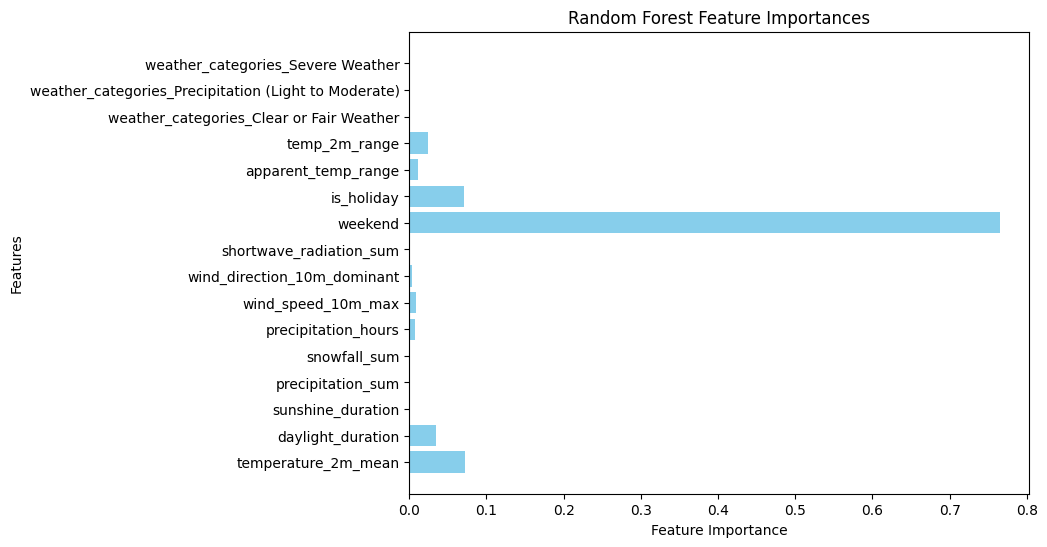


Tuning Random Forest...

Random Forest Model (Tuned):
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50}
Test Root Mean Squared Error: 443943.6769212185
Test Mean Squared Error: 197085988278.33127
Test R-squared: 0.6882778833502334

 Feature Importances: [7.28900131e-02 5.38585645e-02 1.59612373e-02 1.09719915e-02
 8.62061616e-04 9.53006532e-03 2.02663287e-02 1.54439181e-02
 1.99760941e-02 6.61545758e-01 6.00824115e-02 2.13529060e-02
 3.59993797e-02 3.51309525e-04 3.77510366e-04 5.30450592e-04]


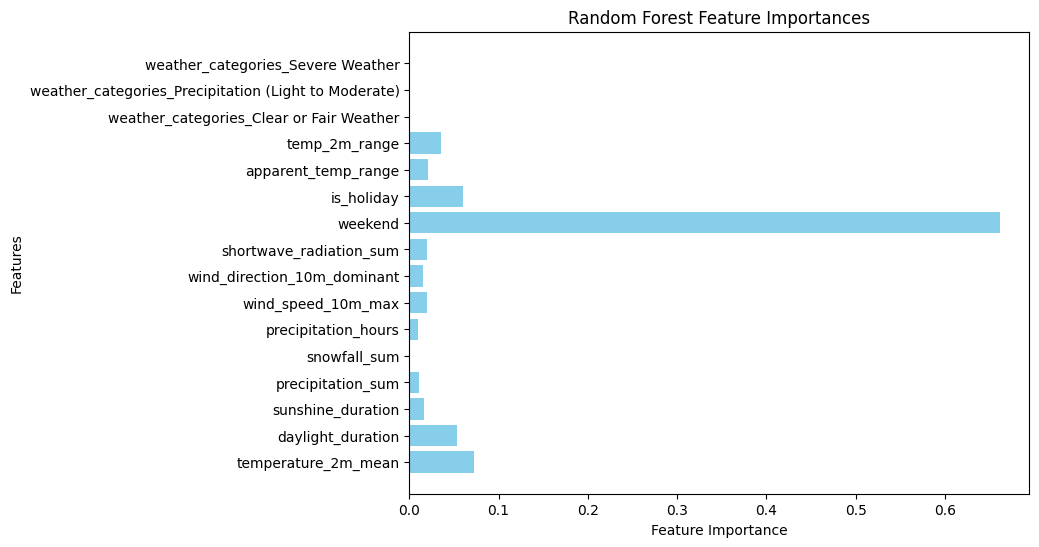


Tuning Gradient Boosting...

Gradient Boosting Model (Tuned):
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Test Root Mean Squared Error: 449038.29100598686
Test Mean Squared Error: 201635386789.57733
Test R-squared: 0.6810823026506752

 Feature Importances: [6.23726659e-02 4.76761488e-02 7.90803323e-03 6.64570051e-03
 1.90350769e-03 5.19697546e-03 1.06852344e-02 7.99393463e-03
 1.57065036e-02 7.29284615e-01 6.84343072e-02 9.01323084e-03
 2.61619188e-02 6.18746298e-05 0.00000000e+00 9.55349204e-04]


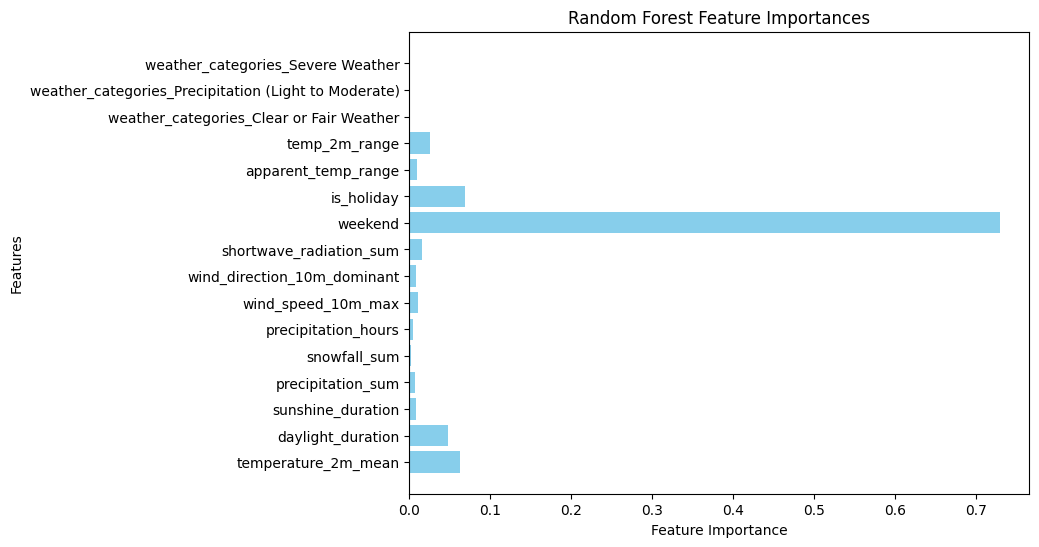

In [264]:
def tune_evaluate_tree_models(X_train, y_train, X_test, y_test, feature_names, existing_df):
    models = {
        "Decision Tree": {
            "model": DecisionTreeRegressor(random_state=42),
            "params": {
                'max_depth': [5, 7, 10],  # Limiting depth for interpretability
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'ccp_alpha': [0.01, 0.05, 0.1] # Pruning
            }
        },
        "Random Forest": {
            "model": RandomForestRegressor(random_state=42),
            "params": {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 4, 6]
            }
        },
        "Gradient Boosting": {
            "model": GradientBoostingRegressor(random_state=42),
            "params": {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 4, 5],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 4, 6]
            }
        }
    }
    results_list = [] # initializing list to store model results
    for name, model_info in models.items():
        print(f"\nTuning {name}...")
        grid_search = GridSearchCV(model_info["model"], model_info["params"], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred) # test mse
        rmse = np.sqrt(mse)

        r2 = r2_score(y_test, y_pred) # test r2

        print(f"\n{name} Model (Tuned):")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Test Root Mean Squared Error: {rmse}")
        print(f"Test Mean Squared Error: {mse}")
        print(f"Test R-squared: {r2}")

        results_list.append({
            'Model Name': name,
            'RMSE': rmse,
            'R-squared': r2,
            'Best Params': grid_search.best_params_
        })

        print(f"\n Feature Importances: {best_model.feature_importances_}")
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, best_model.feature_importances_, color='skyblue')
        plt.xlabel("Feature Importance")
        plt.ylabel("Features")
        plt.title("Random Forest Feature Importances")
        plt.show()
    updated_df = pd.concat([existing_df, pd.DataFrame(results_list)], ignore_index=True)
    return updated_df

feature_names = list(X.columns)
model_comparison_df = tune_evaluate_tree_models(X_train, y_train, X_test, y_test, feature_names, model_comparison_df)

In [265]:
model_comparison_df.head(10)

,Model Name,RMSE,R-squared,Best Params
0,Linear Regression,515576.774501,0.579565,NaN
1,Ridge,515170.577863,0.580228,{'alpha': 1}
2,Lasso,515499.221202,0.579692,{'alpha': 100}
3,ElasticNet,514082.849516,0.581998,"{'alpha': 0.01, 'l1_ratio': 0.5}"
4,Decision Tree,488661.638087,0.622316,"{'ccp_alpha': 0.01, 'max_depth': 5, 'min_sampl..."
5,Random Forest,443943.676921,0.688278,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_..."
6,Gradient Boosting,449038.291006,0.681082,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."


### So far, Random Forest has performed the considering high R-squared of 0.688 and low RMSE of 443,943.

# PCA with Regression and RandomForest

In [266]:
# PCA + Linear Regression with pipeline 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=9)),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred_pca_lr = pipeline.predict(X_test)
mse_pca_lr = mean_squared_error(y_test, y_pred_pca_lr)
r2_pca_lr = r2_score(y_test, y_pred_pca_lr)

print(f"\nPCA Regression Model (Test performance):")
print(f"PCA R-squared: {r2_pca_lr}")
print(f"PCA Root Mean Squared Error: {np.sqrt(mse_pca_lr)}")
print(f"\nPCA Mean Squared Error: {mse_pca_lr}")

pca_lr_results = {'Model Name': 'PCA Regression',
              'RMSE': np.sqrt(mse_pca_lr),
              'R-squared': r2_pca_lr,
              'Best Params': 'n_components = 9'}
model_comparison_df = pd.concat([model_comparison_df, pd.Series(pca_lr_results).to_frame().T], ignore_index=True)




PCA Regression Model (Test performance):
PCA R-squared: 0.5822574736905651
PCA Root Mean Squared Error: 513923.4217846649

PCA Mean Squared Error: 264117283458.85858


In [267]:
# PCA + Random Forest
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# PCA with Random Forest Regressor in a pipeline
pipeline_pca_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=9)),
    ('regressor', RandomForestRegressor(random_state=42))  # Using Random Forest Regressor
])

pipeline_pca_rf.fit(X_train, y_train)
y_pred_pipeline_pca_rf = pipeline_pca_rf.predict(X_test)
mse_pipeline_pca_rf = mean_squared_error(y_test, y_pred_pipeline_pca_rf)
r2_pipeline_pca_rf = r2_score(y_test, y_pred_pipeline_pca_rf)
rmse_pipeline_pca_rf = np.sqrt(mse_pipeline_pca_rf)

print(f"\nPCA with Random Forest Regression Model (Test performance):")
print(f"PCA + RF R-squared: {r2_pipeline_pca_rf}")
print(f"PCA + RF Root Mean Squared Error: {rmse_pipeline_pca_rf}")
print(f"PCA + RF Mean Squared Error: {mse_pipeline_pca_rf}")

# Comparing with Linear Regression PCA model
print(f"\nPCA Regression Model (Test performance):")
print(f"PCA R-squared: {r2_pipeline_pca_rf}")
print(f"PCA Root Mean Squared Error: {np.sqrt(mse_pipeline_pca_rf)}")
print(f"PCA Mean Squared Error: {mse_pipeline_pca_rf}")

pca_rf_results = {'Model Name': 'PCA RanfomForest',
              'RMSE': np.sqrt(mse_pipeline_pca_rf),
              'R-squared': r2_pipeline_pca_rf,
              'Best Params': 'n_components = 9'}
model_comparison_df = pd.concat([model_comparison_df, pd.Series(pca_rf_results).to_frame().T], ignore_index=True)


PCA with Random Forest Regression Model (Test performance):
PCA + RF R-squared: 0.6294891529063608
PCA + RF Root Mean Squared Error: 483999.0730947592
PCA + RF Mean Squared Error: 234255102756.58606

PCA Regression Model (Test performance):
PCA R-squared: 0.6294891529063608
PCA Root Mean Squared Error: 483999.0730947592
PCA Mean Squared Error: 234255102756.58606


In [268]:
model_comparison_df.head(15)

,Model Name,RMSE,R-squared,Best Params
0,Linear Regression,515576.774501,0.579565,NaN
1,Ridge,515170.577863,0.580228,{'alpha': 1}
2,Lasso,515499.221202,0.579692,{'alpha': 100}
3,ElasticNet,514082.849516,0.581998,"{'alpha': 0.01, 'l1_ratio': 0.5}"
4,Decision Tree,488661.638087,0.622316,"{'ccp_alpha': 0.01, 'max_depth': 5, 'min_sampl..."
5,Random Forest,443943.676921,0.688278,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_..."
6,Gradient Boosting,449038.291006,0.681082,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
7,PCA Regression,513923.421785,0.582257,n_components = 9
8,PCA RanfomForest,483999.073095,0.629489,n_components = 9


# Fitting XGBoost and Cat Boost

### XGBoost

In [269]:
# Hyper parameter tunining using GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating DMatrix for XGBoost for faster computation
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', seed=42),
                           param_grid=param_grid, 
                           scoring='r2', 
                           cv=5, 
                           verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500, 'subsample': 0.6}


In [270]:
# Define parameters for XGBoost
params_best = {
    'objective': 'reg:squarederror',
    'max_depth': 4,
    'learning_rate': 0.01,
    'n_estimators': 500,
    'min_child_weight': 10,
    'subsample': 0.6,
    'colsample_bytree': 1.0,
    'seed': 42
}

xgb_regressor_best = xgb.XGBRegressor(**params_best)
xgb_regressor_best.fit(X_train, y_train)
y_pred_xgboost = xgb_regressor_best.predict(X_test)
r2_xgboost = r2_score(y_test, y_pred_xgboost)
mse_xgboost_reg = mean_squared_error(y_test, y_pred_xgboost)
print(f"R-squared: {r2_xgboost}")
print(f"XGBoostRegressor Root Mean Squared Error: {np.sqrt(mse_xgboost_reg)}")
print(f"XGBoostRegressor Mean Squared Error: {mse_xgboost_reg}")

feature_importance_xgboost = xgb_regressor_best.feature_importances_
print("Feature Importances:", feature_importance_xgboost)

xgb_reg_results = {'Model Name': 'XGBoost Regressor',
              'RMSE': np.sqrt(mse_xgboost_reg),
              'R-squared': r2_xgboost,
              'Best Params': grid_search.best_params_}
model_comparison_df = pd.concat([model_comparison_df, pd.Series(xgb_reg_results).to_frame().T], ignore_index=True)

R-squared: 0.6575130224227905
XGBoostRegressor Root Mean Squared Error: 469653.01888096065
XGBoostRegressor Mean Squared Error: 220573958144.0
Feature Importances: [0.02878296 0.02897248 0.0191748  0.0237541  0.02547105 0.01691014
 0.0170158  0.01511429 0.0188688  0.6661152  0.07590447 0.01770584
 0.02717661 0.         0.01903347 0.        ]


In [271]:
model_comparison_df.head(20)

,Model Name,RMSE,R-squared,Best Params
0,Linear Regression,515576.774501,0.579565,NaN
1,Ridge,515170.577863,0.580228,{'alpha': 1}
2,Lasso,515499.221202,0.579692,{'alpha': 100}
3,ElasticNet,514082.849516,0.581998,"{'alpha': 0.01, 'l1_ratio': 0.5}"
4,Decision Tree,488661.638087,0.622316,"{'ccp_alpha': 0.01, 'max_depth': 5, 'min_sampl..."
5,Random Forest,443943.676921,0.688278,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_..."
6,Gradient Boosting,449038.291006,0.681082,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
7,PCA Regression,513923.421785,0.582257,n_components = 9
8,PCA RanfomForest,483999.073095,0.629489,n_components = 9
9,XGBoost Regressor,469653.018881,0.657513,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."


# CATBoost

In [272]:
categorical_features = [
    X.columns.get_loc("weather_categories_Clear or Fair Weather"),
    X.columns.get_loc("weather_categories_Precipitation (Light to Moderate)"),
    X.columns.get_loc("weather_categories_Severe Weather")
]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoost regressor
catboost_regressor = CatBoostRegressor(
    iterations=500,          # Number of trees
    learning_rate=0.05,      # Step size for gradient descent
    depth=6,                 # Tree depth (controls complexity)
    # cat_features=categorical_features,  # Indices of categorical features
    loss_function='RMSE',    # Root Mean Square Error for regression
    verbose=100,             # Display training updates every 100 iterations
    random_seed=42           # For reproducibility
)

catboost_regressor.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)
y_pred_cat = catboost_regressor.predict(X_test)
r2_cat = r2_score(y_test, y_pred_cat)
mse_catboost_reg = mean_squared_error(y_test, y_pred_cat)
print(f"R-squared: {r2_cat}")
print(f"catboost_regressor Root Mean Squared Error: {np.sqrt(mse_catboost_reg)}")
print(f"catboost_regressor Mean Squared Error: {mse_catboost_reg}")
print(f"R-squared: {r2_cat}")

# Feature Importance Analysis
feature_importance_catboost = catboost_regressor.get_feature_importance(prettified=True)
print("Feature Importances:")
print(feature_importance_catboost)

catboost_reg_results = {'Model Name': 'CATBoost Regressor',
              'RMSE': np.sqrt(mse_catboost_reg),
              'R-squared': r2_cat,
              'Best Params': {'iterations':500, 'learning_rate':0.05, 'depth':6, 'loss_function':'RMSE', 'verbose':100} }
model_comparison_df = pd.concat([model_comparison_df, pd.Series(catboost_reg_results).to_frame().T], ignore_index=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 805422.0730606	test: 786023.6338625	best: 786023.6338625 (0)	total: 11.4ms	remaining: 5.7s
100:	learn: 412263.4669883	test: 486601.4691070	best: 486601.4691070 (100)	total: 92.4ms	remaining: 365ms
200:	learn: 354606.7306693	test: 469694.1562845	best: 469694.1562845 (200)	total: 174ms	remaining: 259ms
300:	learn: 302873.7874629	test: 462907.3418860	best: 462907.3418860 (300)	total: 349ms	remaining: 231ms
400:	learn: 264851.3572117	test: 459567.2696352	best: 459396.9541027 (396)	total: 428ms	remaining: 106ms
499:	learn: 236240.5080344	test: 458779.0024233	best: 457475.2483918 (463)	total: 504ms	remaining: 0us

bestTest = 457475.2484
bestIteration = 463

Shrink model to first 464 iterations.
R-squared: 0.6750436536942441
catboost_regressor Root Mean Squared Error: 457475.24839175236
catboost_regressor Mean Squared Error: 209283602891.09555
R-squared: 0.6750436536942441
Feature Importances:
                                           Feature Id  Importances
0                      

# RNN with LSTM
### We're considering fitting an RNN with LSTM because LSTMs, crucial for capturing long-term dependencies in time-series data, which standard RNNs often struggle with. While linear models can identify trends and correlations, and tree-based models can capture non-linear relationships, both often struggle to inherently understand the sequential nature of temporal data.

In [273]:
# Prepare features and target
X_rnn = df.drop(columns=['ridership', 'holidayName', 'weather_code'])
y = df['ridership'].values.astype(np.float32)

# Extract temporal features
X_rnn['year'] = df['date'].dt.year
X_rnn['month'] = df['date'].dt.month
X_rnn['day'] = df['date'].dt.day
X_rnn['day_of_week'] = df['date'].dt.dayofweek
X_rnn['day_of_week_sin'] = np.sin(2 * np.pi * X_rnn['day_of_week'] / 7)
X_rnn['day_of_week_cos'] = np.cos(2 * np.pi * X_rnn['day_of_week'] / 7)
X_rnn = X_rnn.drop(columns=['date']).values.astype(np.float32)

# Scale features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_rnn)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

Training:  13%|█▎        | 13/100 [00:22<02:31,  1.75s/it]

Early stopping at epoch 14


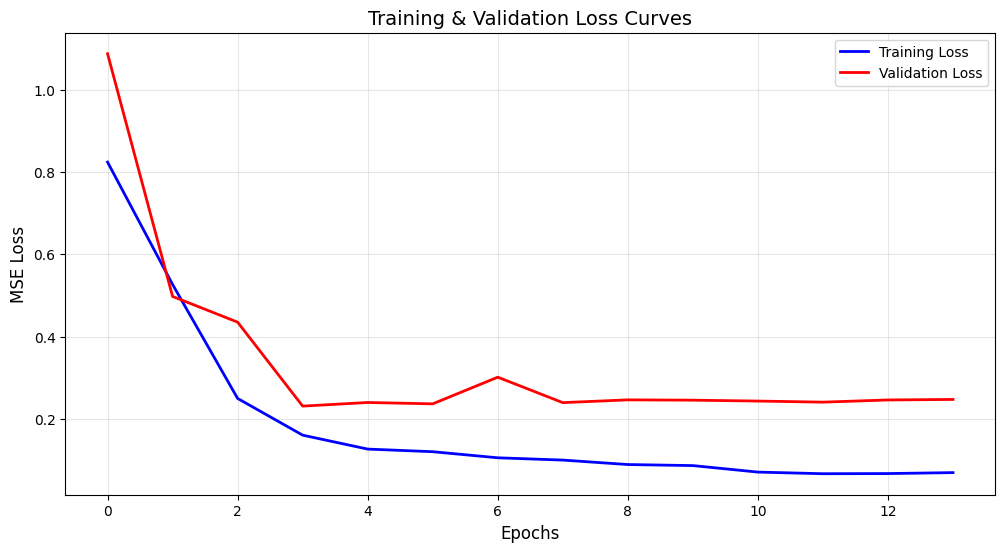


FINAL MODEL TEST SET PERFORMANCE:
RMSE: 429260.74
R²: 0.7286


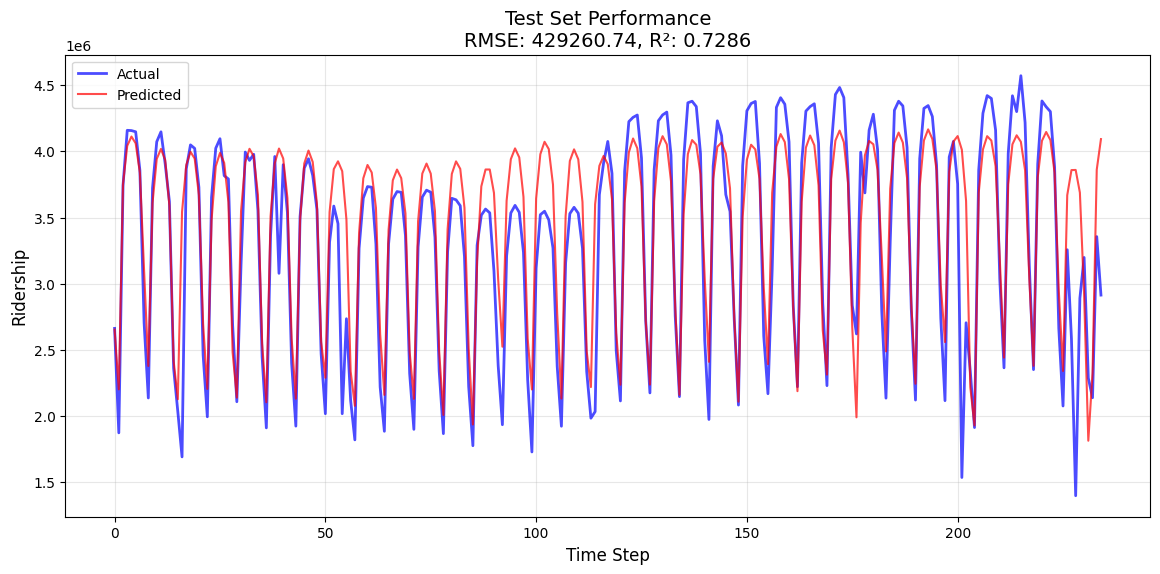

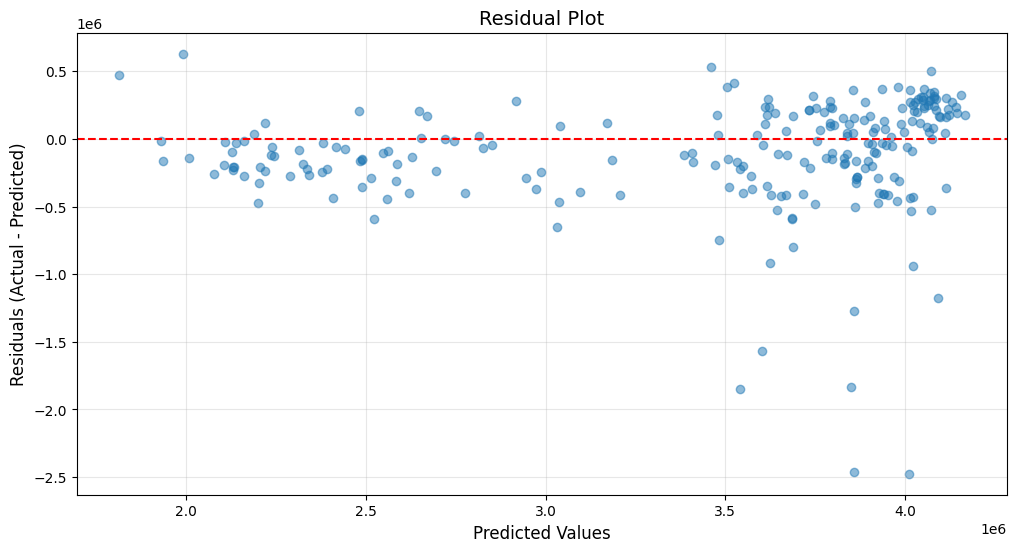

In [274]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Load dataset
file_path = './cleaned_daily_ridership_weather_holi_data.csv'
df = pd.read_csv(file_path, parse_dates=['date'])

# Prepare features and target
X_rnn = df.drop(columns=['ridership', 'holidayName', 'weather_code'])
y = df['ridership'].values.astype(np.float32)

# Extract temporal features
X_rnn['year'] = df['date'].dt.year
X_rnn['month'] = df['date'].dt.month
X_rnn['day'] = df['date'].dt.day
X_rnn['day_of_week'] = df['date'].dt.dayofweek
X_rnn['day_of_week_sin'] = np.sin(2 * np.pi * X_rnn['day_of_week'] / 7)
X_rnn['day_of_week_cos'] = np.cos(2 * np.pi * X_rnn['day_of_week'] / 7)
X_rnn = X_rnn.drop(columns=['date']).values.astype(np.float32)

# Scale features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_rnn)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Chronological train-test split
test_size = 0.2
split_idx = int(len(X_scaled) * (1 - test_size))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Chronological validation split
val_size = 0.2
val_split_idx = int(len(X_train) * (1 - val_size))
X_train_final, X_val = X_train[:val_split_idx], X_train[val_split_idx:]
y_train_final, y_val = y_train[:val_split_idx], y_train[val_split_idx:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_length):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_length], 
                self.y[idx+self.seq_length])

# LSTM Model with Modified Architecture
class RidershipLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(RidershipLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Take the last hidden state
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

# Parameters
seq_length = 30
input_size = X_scaled.shape[1]
hidden_size = 128
num_layers = 2
output_size = 1
batch_size = 32
n_epochs = 100

# Datasets and DataLoaders
train_dataset = TimeSeriesDataset(X_train_final, y_train_final, seq_length)
val_dataset = TimeSeriesDataset(X_val, y_val, seq_length)
test_dataset = TimeSeriesDataset(X_test, y_test, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, optimizer
model = RidershipLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
early_stopping = EarlyStopping(patience=10, delta=0.01)

# Training loop with early stopping
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs), desc="Training"):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            epoch_val_loss += criterion(outputs, y_batch.unsqueeze(1)).item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss)
    
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.title("Training & Validation Loss Curves", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate on Test Set
model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        test_preds.extend(preds.squeeze().numpy())
        test_true.extend(y_batch.numpy())

# Inverse scaling
test_preds_rescaled = scaler_y.inverse_transform(np.array(test_preds).reshape(-1, 1))
test_true_rescaled = scaler_y.inverse_transform(np.array(test_true).reshape(-1, 1))

# Calculate metrics
final_rmse = np.sqrt(mean_squared_error(test_true_rescaled, test_preds_rescaled))
final_r2 = r2_score(test_true_rescaled, test_preds_rescaled)

print(f"\nFINAL MODEL TEST SET PERFORMANCE:")
print(f"RMSE: {final_rmse:.2f}")
print(f"R²: {final_r2:.4f}")

RNN_LSTM_reg_results = {'Model Name': 'RNN LSTM',
              'RMSE': final_rmse,
              'R-squared': final_r2,
              'Best Params': {'seq_length': 30, 'hidden_size': 128, 'num_layer' : 2, 'output_size': 1,'batch_size':32,'n_epochs':100}}
model_comparison_df = pd.concat([model_comparison_df, pd.Series(RNN_LSTM_reg_results).to_frame().T], ignore_index=True)

# Plot Predictions vs Actual
plt.figure(figsize=(14, 6))
plt.plot(test_true_rescaled, label='Actual', color='blue', alpha=0.7, linewidth=2)
plt.plot(test_preds_rescaled, label='Predicted', color='red', alpha=0.7, linewidth=1.5)
plt.title(f"Test Set Performance\nRMSE: {final_rmse:.2f}, R²: {final_r2:.4f}", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Residual Plot
residuals = test_true_rescaled - test_preds_rescaled
plt.figure(figsize=(12, 6))
plt.scatter(test_preds_rescaled, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# # Save the final model
# torch.save(model.state_dict(), 'ridership_lstm_final.pth')
# print("Final model saved to ridership_lstm_final.pth")

In [275]:
model_comparison_df.head(30)

,Model Name,RMSE,R-squared,Best Params
0,Linear Regression,515576.774501,0.579565,NaN
1,Ridge,515170.577863,0.580228,{'alpha': 1}
2,Lasso,515499.221202,0.579692,{'alpha': 100}
3,ElasticNet,514082.849516,0.581998,"{'alpha': 0.01, 'l1_ratio': 0.5}"
4,Decision Tree,488661.638087,0.622316,"{'ccp_alpha': 0.01, 'max_depth': 5, 'min_sampl..."
5,Random Forest,443943.676921,0.688278,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_..."
6,Gradient Boosting,449038.291006,0.681082,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
7,PCA Regression,513923.421785,0.582257,n_components = 9
8,PCA RanfomForest,483999.073095,0.629489,n_components = 9
9,XGBoost Regressor,469653.018881,0.657513,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."


# Prediction test on synthetic data

In [276]:
import datetime

new_date = datetime.date(2025, 7, 1)  # Hypothetical future date
day_of_week = new_date.weekday()

synthetic_row = {

    'temperature_2m_mean': 70, 
    'temp_2m_range': 10,
    'apparent_temperature_mean': 71,
    'apparent_temp_range': 9.229394,
    'daylight_duration': 55520,
    'sunshine_duration':27307.883, 
    'precipitation_sum': 0.003937,
    'snowfall_sum': 0,
    'precipitation_hours': 1,
    'wind_speed_10m_max': 11.887713,
    'wind_direction_10m_dominant': 113.585045,
    'shortwave_radiation_sum': 15.16,
    'weekend': 1,
    'is_holiday': 0, 
    'weather_categories_Clear or Fair Weather': 0,
    'weather_categories_Precipitation (Light to Moderate)': 1,
    'weather_categories_Severe Weather': 0,
    # Add temporal features
    'year': new_date.year,
    'month': new_date.month,
    'day': new_date.day,
    'day_of_week': day_of_week,
    'day_of_week_sin': np.sin(2 * np.pi * day_of_week / 7),
    'day_of_week_cos': np.cos(2 * np.pi * day_of_week / 7)
}

# Convert to DataFrame and scale the features
synthetic_df = pd.DataFrame([synthetic_row])
synthetic_scaled = scaler_X.transform(synthetic_df)

# Combine with the last 29 days from the test set to form a sequence
last_29_days = X_test[-(seq_length - 1):]  # Use the last 29 rows from the test data
synthetic_sequence = np.vstack([last_29_days, synthetic_scaled]).astype(np.float32)

# Convert to tensor for the LSTM model
synthetic_sequence_tensor = torch.tensor(synthetic_sequence).unsqueeze(0)  

# Make the prediction
model.eval()
with torch.no_grad():
    synthetic_prediction_scaled = model(synthetic_sequence_tensor).numpy()

# Rescale the prediction back to the original scale
synthetic_prediction = scaler_y.inverse_transform(synthetic_prediction_scaled)

print(f"Predicted Ridership for {new_date}: {synthetic_prediction[0][0]:.2f}")


Predicted Ridership for 2025-07-01: 3950421.50


/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


##  Use of temporal features such as day of the week yielded better result for RNN + LSTM. Let's explore using such features on our Linear and Tree based models too.

In [277]:
# Prepare features and target
X_temporal_features = df.drop(columns=['ridership', 'holidayName', 'weather_code', 'apparent_temperature_mean', 'precipitation_hours'])
y = df['ridership'].values.astype(np.float32)

# Extract temporal features
# X_temporal_features['year'] = df['date'].dt.year
X_temporal_features['month'] = df['date'].dt.month
X_temporal_features['day'] = df['date'].dt.day
X_temporal_features['day_of_week'] = df['date'].dt.dayofweek
X_temporal_features['day_of_week_sin'] = np.sin(2 * np.pi * X_temporal_features['day_of_week'] / 7)
X_temporal_features['day_of_week_cos'] = np.cos(2 * np.pi * X_temporal_features['day_of_week'] / 7)
# X_temporal_features = X_temporal_features.drop(columns=['date']).values.astype(np.float32)
X_temporal_features = X_temporal_features.drop(columns=['date']) #.values.astype(np.float32)
# standardizing data
scaler = StandardScaler()
X_scaled_temoral_features = scaler.fit_transform(X_temporal_features)

# Split data
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_scaled_temoral_features, y, test_size=0.3, random_state=42)
X_temporal_features.head()

# Save fitted scaler, which will be helpful during predictin scoring
scaler_filename = "./scaler_temporal_features.pkl"
joblib.dump(scaler, scaler_filename)
print(f"Scaler for temporal features saved to: {scaler_filename}")

Scaler for temporal features saved to: ./scaler_temporal_features.pkl


R-squared: 0.580
RMSE: 515371.08
Mean Squared Error: 265607349567.05
Coefficients: [ -51785.88670578 -112552.84353701  -97947.93454316  -26454.47808778
  -32489.23908913  -26044.53742657  -46724.24487159  108697.82020066
 -634665.2045583  -196888.72369897 -102661.08735969  224934.7424147
    8420.50201249   13194.23692384  -49242.77056159   18214.09238777]
Intercept: 2956487.96

Feature Importance:
temp_2m_range                                           224934.742415
shortwave_radiation_sum                                 108697.820201
day_of_week                                              18214.092388
weather_categories_Precipitation (Light to Moderate)     13194.236924
weather_categories_Clear or Fair Weather                  8420.502012
wind_speed_10m_max                                      -26044.537427
precipitation_sum                                       -26454.478088
snowfall_sum                                            -32489.239089
wind_direction_10m_dominant           

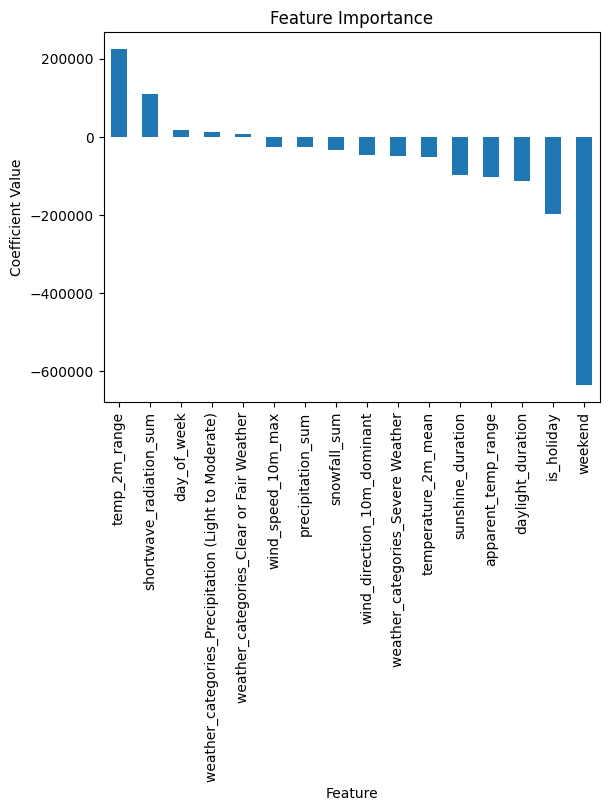

In [278]:
# Training linear model with temporal features
# standardizing data
scaler_lr = StandardScaler()
x_temp_feat_lr = X_temporal_features.drop(columns=['month', 'day', 'day_of_week_sin', 'day_of_week_cos'])
X_scaled_temoral_lr = scaler_lr.fit_transform(x_temp_feat_lr)

# Split data
X_train_tf_lr, X_test_tf_lr, y_train_tf_lr, y_test_tf_lr = train_test_split(X_scaled_temoral_lr, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train_tf_lr, y_train_tf_lr)
y_pred_lr = model.predict(X_test_tf_lr)
mse_lr = mean_squared_error(y_test_tf_lr, y_pred_lr)
r2_lr = r2_score(y_test_tf_lr, y_pred_lr)

# joblib.dump(model, './linear_regression_model.pkl')

print(f"R-squared: {r2_lr:.3f}")
rmse_lr = np.sqrt(mse_lr) 
print(f"RMSE: {rmse_lr:.2f}")
print(f"Mean Squared Error: {mse_lr:.2f}")
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_:.2f}")
results_list = []
results_list.append({
    'Model Name': f'Linear Regression + temporal_features',
    'RMSE': rmse_lr,
    'R-squared': r2_lr,
    'Best Params': None
})

# Append all results at once
model_comparison_df = pd.concat([model_comparison_df, pd.DataFrame(results_list)], ignore_index=True)

# extracting feature importance (coefficients)
feature_importance = pd.Series(model.coef_, index=x_temp_feat_lr.columns).sort_values(ascending=False)

# visualizing feature importance
print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
feature_importance.plot(kind='bar', title="Feature Importance")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.show()

### Not much difference. Temporal elements mightly add more multicollinearity since month, day of week, day, day of week sin/cos, are related.

OLS Model Results:
R-squared: 0.580
RMSE: 515371.08
Mean Squared Error: 265607349567.05

Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     114.3
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          2.93e-197
Time:                        09:18:36   Log-Likelihood:                -13467.
No. Observations:                 927   AIC:                         2.697e+04
Df Residuals:                     911   BIC:                         2.704e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.0

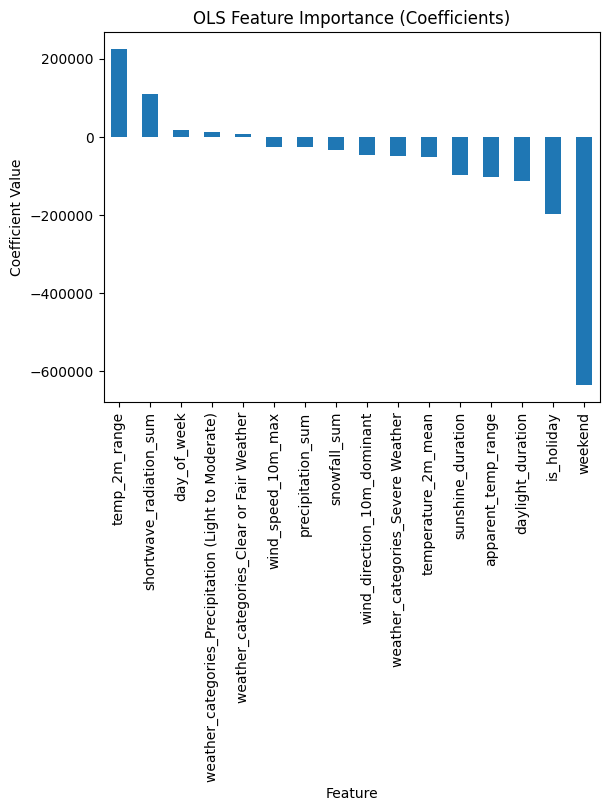

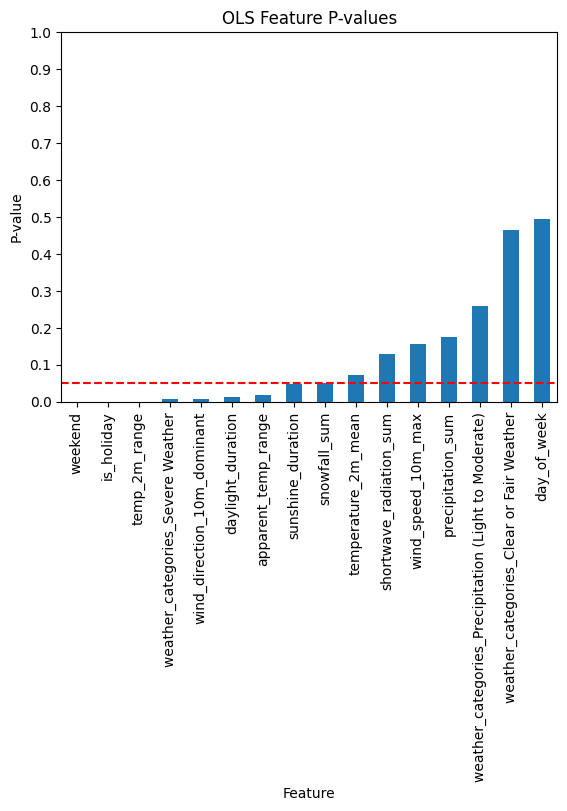

In [279]:
# Training Linear Regression with OLS for P-Values and better interpretations

# Convert scaled arrays back to DataFrames with original column names
X_train_scaled_df = pd.DataFrame(X_train_tf_lr, columns=x_temp_feat_lr.columns)
X_test_scaled_df = pd.DataFrame(X_test_tf_lr, columns=x_temp_feat_lr.columns)

# Add a constant term to the independent variables
X_train_ols = sm.add_constant(X_train_scaled_df)
X_test_ols = sm.add_constant(X_test_scaled_df)

# Train the OLS model using statsmodels
ols_model = sm.OLS(y_train_tf, X_train_ols).fit()

# Make predictions
y_pred_ols = ols_model.predict(X_test_ols)

# Evaluate the model
mse_ols = mean_squared_error(y_test_tf, y_pred_ols)
r2_ols = r2_score(y_test_tf, y_pred_ols)
rmse_ols = np.sqrt(mse_ols)

print("OLS Model Results:")
print(f"R-squared: {r2_ols:.3f}")
print(f"RMSE: {rmse_ols:.2f}")
print(f"Mean Squared Error: {mse_ols:.2f}")
print("\nModel Summary:")
print(ols_model.summary())

# Extract feature importance (coefficients) and p-values
coefficients = ols_model.params[1:]  # Exclude the constant term
p_values = ols_model.pvalues[1:]     # Exclude the constant term

feature_importance_ols = pd.Series(coefficients, index=X_train_scaled_df.columns).sort_values(ascending=False)
p_values_series = pd.Series(p_values, index=X_train_scaled_df.columns).sort_values()

print("\nFeature Importance (Coefficients):")
print(feature_importance_ols)

print("\nP-values:")
print(p_values_series.apply(lambda x: f"{x:.3f}"))

# Plot feature importance (coefficients)
feature_importance_ols.plot(kind='bar', title="OLS Feature Importance (Coefficients)")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.show()

# Plot p-values
plt.figure()
p_values_series.plot(kind='bar', title="OLS Feature P-values")
plt.ylabel("P-value")
plt.xlabel("Feature")
plt.axhline(0.05, color='r', linestyle='--') # Significance threshold
plt.yticks(np.arange(0, 1.1, 0.1)) # Ensure y-axis shows values from 0 to 1
plt.show()

In [280]:
# Regularized Regression + Hyper parameter Tuining
def train_evaluate_regularized_models(X_train, y_train, X_test, y_test, feature_names, existing_df):
    models = {
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        "ElasticNet": ElasticNet()
    }

    param_grids = {
        "Ridge": {'alpha': [0.01, 0.1, 1, 10, 100]}, 'max_iter' : [10000],
        "Lasso": {'alpha': [0.01, 0.1, 1, 10, 100]},
        "ElasticNet": {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]}
    }
    results_list = []
    for name, model in models.items():
        # Hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Predictions and metrics
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred)

        print(f"\n{name} Model (Best Params: {grid_search.best_params_}):")
        print(f"Overall R-squared: {r2:.3f}")
        print(f"Training R-squared: {r2_train:.3f}")
        print(f"Testing R-squared: {r2_test:.3f}")
        print(f"Training RMSE: {np.sqrt(mse_train):.2f}")
        print(f"Testing RMSE: {np.sqrt(mse_test):.2f}")

        # Feature importance (coefficients)
        importance = pd.Series(best_model.coef_, index=feature_names).sort_values(ascending=False)
        print("\nFeature Importance (coefficients):")
        print(importance)
    
        results_list.append({
            'Model Name': f'{name} + temporal_features',
            'RMSE': np.sqrt(mse_test),
            'R-squared': r2_test,
            'Best Params': grid_search.best_params_
        })

    # Append all results at once
    updated_df = pd.concat([existing_df, pd.DataFrame(results_list)], ignore_index=True)
    return updated_df


feature_names = X_temporal_features.columns.to_list()
model_comparison_df = train_evaluate_regularized_models(X_train_tf, y_train_tf, X_test_tf, y_test_tf, feature_names, model_comparison_df)


Ridge Model (Best Params: {'alpha': 10}):
Overall R-squared: 0.580
Training R-squared: 0.701
Testing R-squared: 0.631
Training RMSE: 457826.07
Testing RMSE: 482812.12

Feature Importance (coefficients):
temp_2m_range                                           204304.149150
day_of_week_sin                                         143926.982659
month                                                   102717.931027
shortwave_radiation_sum                                  98657.070287
weather_categories_Precipitation (Light to Moderate)     12796.302540
weather_categories_Clear or Fair Weather                 -2137.990993
wind_speed_10m_max                                      -14464.844434
weather_categories_Severe Weather                       -24255.469101
daylight_duration                                       -25820.021024
precipitation_sum                                       -29668.713510
snowfall_sum                                            -37098.739350
wind_direction_10m_dominan

/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.487e+10, tolerance: 5.059e+10
  model = cd_fast.enet_coordinate_descent(
/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.497e+10, tolerance: 5.131e+10
  model = cd_fast.enet_coordinate_descent(
/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec


Lasso Model (Best Params: {'alpha': 100}):
Overall R-squared: 0.580
Training R-squared: 0.701
Testing R-squared: 0.630
Training RMSE: 457621.72
Testing RMSE: 483417.16

Feature Importance (coefficients):
temp_2m_range                                           226198.493295
day_of_week_sin                                         139878.755194
shortwave_radiation_sum                                 129603.805293
month                                                   107142.104800
weather_categories_Precipitation (Light to Moderate)     19575.389186
weather_categories_Clear or Fair Weather                    -0.000000
wind_speed_10m_max                                      -15915.562971
weather_categories_Severe Weather                       -23007.039626
precipitation_sum                                       -28243.129730
daylight_duration                                       -31557.686346
snowfall_sum                                            -37315.400552
wind_direction_10m_domina

/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e+11, tolerance: 5.059e+10
  model = cd_fast.enet_coordinate_descent(
/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.424e+10, tolerance: 5.131e+10
  model = cd_fast.enet_coordinate_descent(
/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec


ElasticNet Model (Best Params: {'alpha': 0.1, 'l1_ratio': 0.9}):
Overall R-squared: 0.580
Training R-squared: 0.701
Testing R-squared: 0.631
Training RMSE: 457801.29
Testing RMSE: 482847.84

Feature Importance (coefficients):
temp_2m_range                                           205788.383927
day_of_week_sin                                         143649.124189
month                                                   103038.123231
shortwave_radiation_sum                                 100625.733202
weather_categories_Precipitation (Light to Moderate)     12969.742717
weather_categories_Clear or Fair Weather                 -2289.178008
wind_speed_10m_max                                      -14562.207046
weather_categories_Severe Weather                       -24302.910768
daylight_duration                                       -26129.600848
precipitation_sum                                       -29585.553759
snowfall_sum                                            -37115.770925
win

/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.668e+13, tolerance: 5.348e+10
  model = cd_fast.enet_coordinate_descent(
/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.508e+13, tolerance: 5.192e+10
  model = cd_fast.enet_coordinate_descent(


In [281]:
model_comparison_df.head(25)

,Model Name,RMSE,R-squared,Best Params
0,Linear Regression,515576.774501,0.579565,NaN
1,Ridge,515170.577863,0.580228,{'alpha': 1}
2,Lasso,515499.221202,0.579692,{'alpha': 100}
3,ElasticNet,514082.849516,0.581998,"{'alpha': 0.01, 'l1_ratio': 0.5}"
4,Decision Tree,488661.638087,0.622316,"{'ccp_alpha': 0.01, 'max_depth': 5, 'min_sampl..."
5,Random Forest,443943.676921,0.688278,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_..."
6,Gradient Boosting,449038.291006,0.681082,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
7,PCA Regression,513923.421785,0.582257,n_components = 9
8,PCA RanfomForest,483999.073095,0.629489,n_components = 9
9,XGBoost Regressor,469653.018881,0.657513,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."


# Retraining Tree based models using Temporal features such as day of week, month, day, etc.


Tuning Decision Tree...

Decision Tree Model (Tuned):
Best Parameters: {'ccp_alpha': 0.01, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Test Root Mean Squared Error: 431543.27479571407
Test Mean Squared Error: 186229598021.40918
Test R-squared: 0.7054489515708946

 Feature Importances: [0.05098015 0.02626396 0.00586058 0.00447517 0.         0.00136966
 0.00162791 0.00310654 0.75055634 0.06819178 0.00506774 0.01780902
 0.         0.         0.         0.00996629 0.         0.00166872
 0.01363141 0.03942471]


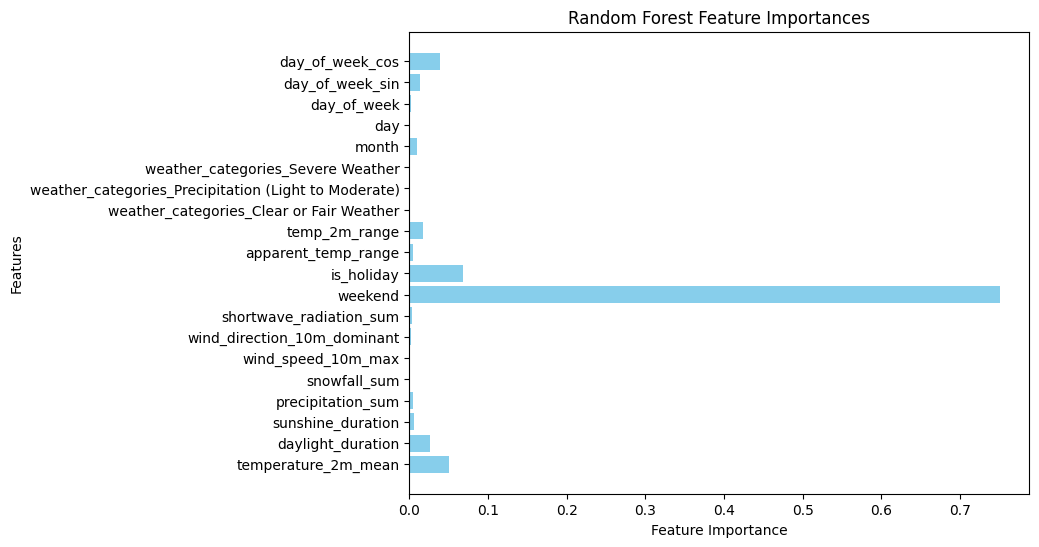


Tuning Random Forest...

Random Forest Model (Tuned):
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test Root Mean Squared Error: 398865.9218665996
Test Mean Squared Error: 159094023626.49234
Test R-squared: 0.7483680792104757

Best RandomForest model saved as 'best_random_forest_model.pkl'

 Feature Importances: [6.40774535e-02 4.88224516e-02 2.01227335e-02 1.63192908e-02
 1.38706200e-03 2.67183487e-02 2.18975038e-02 2.07576125e-02
 1.55228751e-01 5.08385586e-02 2.19581392e-02 3.90221488e-02
 1.32180770e-03 9.17563462e-04 1.79622295e-04 2.24072487e-02
 2.49953694e-02 2.48577282e-01 2.01605822e-01 1.28452305e-02]


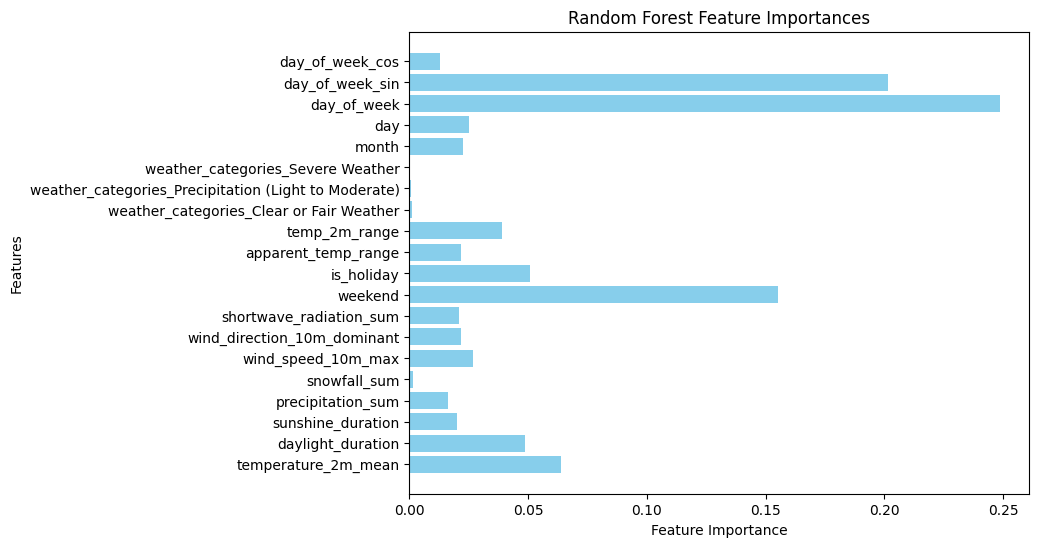


Tuning Gradient Boosting...

Gradient Boosting Model (Tuned):
Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Test Root Mean Squared Error: 405769.0442576775
Test Mean Squared Error: 164648517277.78903
Test R-squared: 0.7395827843601149

 Feature Importances: [5.97471707e-02 4.11192768e-02 1.46752930e-02 1.55767083e-02
 2.29816316e-03 1.82084641e-02 1.52955140e-02 1.61652032e-02
 2.80262049e-01 5.22202206e-02 1.63002209e-02 3.67114504e-02
 2.38159798e-04 4.39129688e-04 0.00000000e+00 2.78068278e-02
 1.98709223e-02 2.28373571e-01 1.37613520e-01 1.70781349e-02]


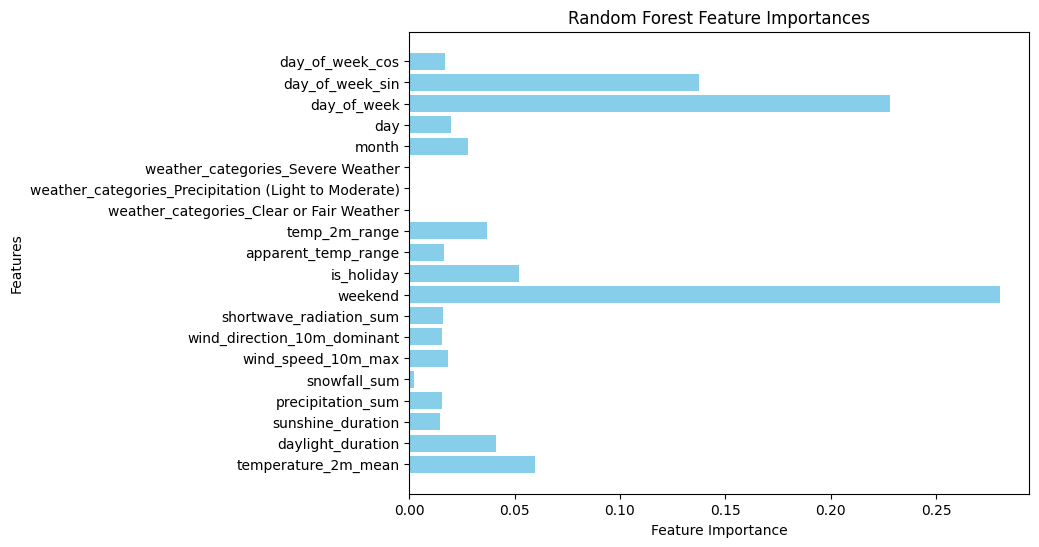

In [282]:
# Tree Based models
def tune_evaluate_tree_models(X_train, y_train, X_test, y_test, feature_names, existing_df):
    models = {
        "Decision Tree": {
            "model": DecisionTreeRegressor(random_state=42),
            "params": {
                'max_depth': [5, 7, 10],  # Limiting depth for interpretability
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'ccp_alpha': [0.01, 0.05, 0.1] # Pruning
            }
        },
        "Random Forest": {
            "model": RandomForestRegressor(random_state=42),
            "params": {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 4, 6]
            }
        },
        "Gradient Boosting": {
            "model": GradientBoostingRegressor(random_state=42),
            "params": {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 4, 5],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 4, 6]
            }
        }
    }
    results_list = []
    for name, model_info in models.items():
        print(f"\nTuning {name}...")
        grid_search = GridSearchCV(model_info["model"], model_info["params"], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        r2 = r2_score(y_test, y_pred)

        print(f"\n{name} Model (Tuned):")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Test Root Mean Squared Error: {rmse}")
        print(f"Test Mean Squared Error: {mse}")
        print(f"Test R-squared: {r2}")
        
        results_list.append({
            'Model Name': f'{name} + temporal_features',
            'RMSE': rmse,
            'R-squared': r2,
            'Best Params': grid_search.best_params_
        })

        if name == "Random Forest":
            joblib.dump(best_model, "./best_random_forest_model.pkl")
            print("\nBest RandomForest model saved as 'best_random_forest_model.pkl'")

        print(f"\n Feature Importances: {best_model.feature_importances_}")
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, best_model.feature_importances_, color='skyblue')
        plt.xlabel("Feature Importance")
        plt.ylabel("Features")
        plt.title("Random Forest Feature Importances")
        plt.show()
    updated_df = pd.concat([existing_df, pd.DataFrame(results_list)], ignore_index=True)
    return updated_df
feature_names = X_temporal_features.columns.to_list()
model_comparison_df = tune_evaluate_tree_models(X_train_tf, y_train_tf, X_test_tf, y_test_tf, feature_names, model_comparison_df)

# CATBoost with additional Temporal features

In [283]:
categorical_features = [
    X.columns.get_loc("weather_categories_Clear or Fair Weather"),
    X.columns.get_loc("weather_categories_Precipitation (Light to Moderate)"),
    X.columns.get_loc("weather_categories_Severe Weather")
]

# Initialize the CatBoost regressor
catboost_regressor = CatBoostRegressor(
    iterations=500,          # Number of trees
    learning_rate=0.05,      # Step size for gradient descent
    depth=6,                 # Tree depth (controls complexity)
    # cat_features=categorical_features,  # Indices of categorical features
    loss_function='RMSE',    # Root Mean Square Error for regression
    verbose=100,             # Display training updates every 100 iterations
    random_seed=42           # For reproducibility
)


catboost_regressor.fit(X_train_tf, y_train_tf, eval_set=(X_test_tf, y_test_tf), plot=True)
y_pred_catb = catboost_regressor.predict(X_test_tf)
r2_cat = r2_score(y_test_tf, y_pred_catb)
mse_cat = mean_squared_error(y_test_tf, y_pred_catb)
rmse_cat = np.sqrt(mse_cat)
print(f"R-squared: {r2_cat}")
print(f"RMSE: {rmse_cat}")

catboost_reg_results = {'Model Name': 'CATBoost Regressor + temporal_features',
              'RMSE': rmse_cat,
              'R-squared': r2_cat,
              'Best Params': {'iterations':500, 'learning_rate':0.05, 'depth':6, 'loss_function':'RMSE', 'verbose':100} }
model_comparison_df = pd.concat([model_comparison_df, pd.Series(catboost_reg_results).to_frame().T], ignore_index=True)
# Feature Importance Analysis
feature_importance_catboost = catboost_regressor.get_feature_importance(prettified=True)
print("Feature Importances:")
print(feature_importance_catboost)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 814588.0856810	test: 778668.5186088	best: 778668.5186088 (0)	total: 7.66ms	remaining: 3.82s
100:	learn: 373075.2201640	test: 423371.0800691	best: 423371.0800691 (100)	total: 85.3ms	remaining: 337ms
200:	learn: 301893.8624584	test: 415047.4127463	best: 415047.4127463 (200)	total: 166ms	remaining: 247ms
300:	learn: 251091.4099607	test: 412144.7313938	best: 411716.8293836 (290)	total: 252ms	remaining: 166ms
400:	learn: 211317.6154071	test: 410458.2826504	best: 410390.9961748 (364)	total: 336ms	remaining: 83.1ms
499:	learn: 181235.1395320	test: 409331.3626741	best: 409241.2492744 (461)	total: 414ms	remaining: 0us

bestTest = 409241.2493
bestIteration = 461

Shrink model to first 462 iterations.
R-squared: 0.7351068849148312
RMSE: 409241.2492744249
Feature Importances:
   Feature Id  Importances
0          18    20.670315
1           8    16.922490
2          17    11.303650
3           0     6.564777
4           9     6.019791
5           1     5.939887
6          15     4.270014

# FINAL MODELS COMPARISON

In [284]:
sorted_result_df = model_comparison_df.sort_values(by=['R-squared', 'RMSE', 'Model Name'],
                                            ascending=[False, True, True])

sorted_result_df.to_csv('Models Result Comparison.csv', index=False)
print("Models Result Comparison exported to predicted_data.csv\n")

print("Sorted Model Performance:")
sorted_result_df.head(50)

Models Result Comparison exported to predicted_data.csv

Sorted Model Performance:


,Model Name,RMSE,R-squared,Best Params
17,Random Forest + temporal_features,398865.921867,0.748368,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
18,Gradient Boosting + temporal_features,405769.044258,0.739583,"{'learning_rate': 0.2, 'max_depth': 4, 'min_sa..."
19,CATBoost Regressor + temporal_features,409241.249274,0.735107,"{'iterations': 500, 'learning_rate': 0.05, 'de..."
11,RNN LSTM,429260.743511,0.728551,"{'seq_length': 30, 'hidden_size': 128, 'num_la..."
16,Decision Tree + temporal_features,431543.274796,0.705449,"{'ccp_alpha': 0.01, 'max_depth': 5, 'min_sampl..."
5,Random Forest,443943.676921,0.688278,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_..."
6,Gradient Boosting,449038.291006,0.681082,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
10,CATBoost Regressor,457475.248392,0.675044,"{'iterations': 500, 'learning_rate': 0.05, 'de..."
9,XGBoost Regressor,469653.018881,0.657513,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
13,Ridge + temporal_features,482812.123485,0.631304,{'alpha': 10}


### Clearly, Randfom Forest with temporal features outperformed other models based on high R-Squared of 0.748 and RMSE 398,865. We will use the Random Forest model for Predction.

## Test runnig the Random forest model Prediction

In [285]:
X_temporal_features.head()

,temperature_2m_mean,daylight_duration,sunshine_duration,precipitation_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,weekend,is_holiday,apparent_temp_range,temp_2m_range,weather_categories_Clear or Fair Weather,weather_categories_Precipitation (Light to Moderate),weather_categories_Severe Weather,month,day,day_of_week,day_of_week_sin,day_of_week_cos
0,61.965496,52304.660,48824.312,0.0,0.0,11.805341,219.91373,25.93,0.0,0.0,27.062177,24.030000,1,0,0,5,17,0,0.000000,1.000000
1,66.926750,52414.355,48361.410,0.0,0.0,9.223387,254.71307,24.97,0.0,0.0,28.330824,27.720000,1,0,0,5,18,1,0.781831,0.623490
2,69.382990,52521.727,49024.887,0.0,0.0,11.858211,350.79745,28.52,0.0,0.0,28.296270,28.080000,1,0,0,5,19,2,0.974928,-0.222521
3,61.635498,52626.652,49004.203,0.0,0.0,12.545163,145.46165,28.03,0.0,0.0,15.383074,16.740000,1,0,0,5,20,3,0.433884,-0.900969
4,63.814250,52728.977,49215.938,0.0,0.0,12.211643,173.92244,28.03,0.0,0.0,22.319097,20.339998,1,0,0,5,21,4,-0.433884,-0.900969


In [287]:
# This chunk of code laods the model, preprocess the input data, and spits out the Daily NYC Ridership Prediction
def preprocess_date(df):
    # Preprocesses the date feature by extracting relevant components.
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df = df.drop('date', axis=1)
    return df

def load_model_and_scaler(model_path, scaler_path):
    # Loads the trained model and scaler from the specified file paths.
    try:
        with open(model_path, 'rb') as file:
            model = joblib.load(file)
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        model = None

    try:
        with open(scaler_path, 'rb') as file:
            scaler = joblib.load(file)
    except FileNotFoundError:
        print(f"Error: Scaler file not found at {scaler_path}")
        scaler = None

    return model, scaler

def preprocess_features(data, scaler):
    # Preprocesses the input features using the loaded scaler.
    if scaler is None:
        print("Error: Scaler not loaded. Cannot preprocess features.")
        return None
    scaled_data = scaler.transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
    return scaled_df

def make_prediction(model, preprocessed_data):
    # Makes predictions using the loaded model and preprocessed data.
    if model is None:
        print("Error: Model not loaded. Cannot make predictions.")
        return None
    predictions = model.predict(preprocessed_data)
    return predictions

if __name__ == "__main__":
    model_file_path = 'best_random_forest_model.pkl' 
    scaler_file_path = 'scaler_temporal_features.pkl' 

    # Load the model and scaler
    loaded_model, loaded_scaler = load_model_and_scaler(model_file_path, scaler_file_path)

    if loaded_model and loaded_scaler:
        # --- Get input data for prediction ---
        input_data = { # This input data will be coming from the FRONT END USER INTERACTION
            'date': ['2025-04-15'],  
            'temperature_2m_mean': [15.0],
            'daylight_duration': [13.5],
            'sunshine_duration': [10.0],
            'precipitation_sum': [0.0],
            'snowfall_sum': [0.0],
            'wind_speed_10m_max': [5.0],
            'wind_direction_10m_dominant': [270],
            'shortwave_radiation_sum': [20.0],
            'weekend': [0],
            'is_holiday': [0],
            'apparent_temp_range': [10.0],
            'temp_2m_range': [8.0],
            'weather_categories_Clear or Fair Weather': [1],
            'weather_categories_Precipitation (Light to Moderate)': [0],
            'weather_categories_Severe Weather': [0]
            #'month', 'day', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos' will be generated from the 'date' column 
            # using preprocess_date()
            
        }
        input_df = pd.DataFrame(input_data)

        # Preprocess the date temproal feature ---
        input_df_processed_date = preprocess_date(input_df.copy())

        # Select the features that were used for training. Very import to have the same order of columns that was used for RandomForest training
        feature_columns_to_scale = [
            'temperature_2m_mean', 'daylight_duration', 'sunshine_duration',
            'precipitation_sum', 'snowfall_sum', 'wind_speed_10m_max',
            'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'weekend',
            'is_holiday', 'apparent_temp_range', 'temp_2m_range',
            'weather_categories_Clear or Fair Weather',
            'weather_categories_Precipitation (Light to Moderate)',
            'weather_categories_Severe Weather', 'month', 'day', 'day_of_week',
            'day_of_week_sin', 'day_of_week_cos'
        ]

        # Ensure all required columns are present
        if all(col in input_df_processed_date.columns for col in feature_columns_to_scale):
            input_df_for_scaling = input_df_processed_date[feature_columns_to_scale]

            # Preprocess and scale all features using the loaded scaler that was used for model training
            scaled_features_df = preprocess_features(input_df_for_scaling, loaded_scaler)

            if scaled_features_df is not None:
                # Make the prediction 
                prediction = make_prediction(loaded_model, scaled_features_df)

                if prediction is not None:
                    print("Daily NYC Subway Ridership Prediction:", prediction)
                else:
                    print("Prediction failed.")
            else:
                print("Feature scaling failed.")
        else:
            print("Error: Not all required features are present in the input data.")
            missing_features = [col for col in feature_columns_to_scale if col not in input_df_processed_date.columns]
            print("Missing features:", missing_features)

    else:
        print("Failed to load model or scaler.")

Daily NYC Subway Ridership Prediction: [3205688.30996428]


/Users/kshitijgurung/opt/anaconda3/envs/cse6242/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
